# Sprite Attitude and Orbital Dynamics

#### V. Hunter Adams (vha3@cornell.edu)

In [1]:
from IPython.display import Latex
import matplotlib.pyplot as plt
%matplotlib inline
import numpy
import numpy.linalg
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
import random
from numpy.linalg import pinv
from scipy import interpolate

Ultimately, the orbital dynamics model for the Sprites will include first and second-order gravitational terms, solar pressure, and atmospheric drag. Higher-order geopotential terms and third-body perturbations are neglected because they are negligibly small in comparison to the dominant terms and perturbations. For sake of testing, the models for both orbital and attitude dynamics will be built up modularly. For a first iteration, the orbital dynamics will include only the first two terms of the geopotential model, omitting external forces.

## Assumptions

1. The magnetic field is static, always pointing North (to be improved later)
2. The antennae can be modeled as a Kane Damper
3. Higher-than-J2 gravitational terms are negligible
4. Third-body gravitational perturbations are negligible
5. Drag and solar pressure are dominant sources of external force/torque

## Orbital Dynamics

### Theory

The Lagrangian for the spacecraft is formed by subtracting the potential from the kinetic energy:

\begin{align}
\mathcal{L} &= T-V
\end{align}

#### Kinetic Energy

We will operate in an Earth-Centered Inertial coordinate frame. This places the origin on the center of the Earth, and lets the Earth rotate on top of the static coordinate system. In this coordinate system, the kinetic energy of the spacecraft is given simply by:

\begin{align}
T &= \frac{1}{2}m\dot{\underline{r}}^{2}
\end{align}

where $\underline{\dot{r}}$ is the time derivative of the position of the spacecraft. In an ECI coordinate frame, the position of the spacecraft is given by:

\begin{align}
\underline{r} &= x\hat{i} + y\hat{j} + z\hat{k}
\end{align}

Taking the time derivative:

\begin{align}
\underline{\dot{r}} &= \dot{x}\hat{i} + \dot{y}\hat{j} + \dot{z}\hat{k}\\
&= \begin{bmatrix}
\dot{x}\\\dot{y}\\\dot{z}
\end{bmatrix}
\end{align}

This gives a kinetic energy expression:

\begin{align}
T &= \frac{1}{2}m\underline{\dot{r}}^T\underline{\dot{r}}\\
&= \frac{1}{2}m\left[\dot{x}^2 + \dot{y}^2 + \dot{z}^2\right]
\end{align}

#### Potential Energy

The first two terms of the gravitational potential expression:

\begin{align}
V &= -\frac{G M_{E}m}{||\underline{r}||} + \frac{J_2m}{2||\underline{r}||^5}(3z^2 - ||\underline{r}||^2)
\end{align}

The first term is the point-mass gravitational term (dominant), the second is the J2 term associated with Earth's equatorial oblateness. This terms causes nodal precession of the Sprite orbits. Rewriting in terms of the state variables:

\begin{align}
V &= -\frac{G M_{E}m}{\left(x^2 + y^2 + z^2\right)^\frac{1}{2}} + \frac{J_2m}{2\left(x^2+y^2+z^2\right)^{\frac{5}{2}}} \left(3z^2 - \left(x^2+y^2+z^2\right)\right)
\end{align}

#### Assemble Lagrangian

Putting the kinetic and potential energy together:

\begin{align}
\mathcal{L} &= T - V\\
&= \frac{1}{2}m\left[\dot{x}^2 + \dot{y}^2 + \dot{z}^2\right]+\frac{G M_{E}m}{\left(x^2 + y^2 + z^2\right)^\frac{1}{2}} - \frac{J_2m}{2\left(x^2+y^2+z^2\right)^{\frac{5}{2}}} \left(3z^2 - \left(x^2+y^2+z^2\right)\right)
\end{align}

#### Euler-Lagrange Equation

In order to find the equation of motion for each state variable ($x$, $y$, $z$), we solve the Euler-Lagrange Equation:

\begin{align}
\frac{\partial{\mathcal{L}}}{\partial{q_i}} - \frac{d}{dt}\frac{\partial{\mathcal{L}}}{\partial{\dot{q_i}}} &= Q_{i}
\end{align}

Since, for now, we are assuming no external forces, $Q_i = 0$. $q_i$ is the $i^{th}$ state variable. Solving:

\begin{align}
\frac{d}{dt}\frac{\partial{\mathcal{L}}}{\partial{\dot{x}}} &= m\ddot{x}\\
\frac{\partial{\mathcal{L}}}{\partial{x}} &= -\frac{G m M_e x}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m x \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}+\frac{J_2 m x}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

Thus, the equation of motion for the $x$ state variable is given by:

\begin{align}
0 &= -\frac{G m M_e x}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m x \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}+\frac{J_2 m x}{\left(x^2+y^2+z^2\right)^{5/2}} - m\ddot{x}\\
\ddot{x} &=  -\frac{G M_e x}{\left(x^2+y^2+z^2\right)^{3/2}} + \frac{5 J_2 x \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}} + \frac{J_2 x}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

Similarly for $y$:

\begin{align}
\frac{d}{dt}\frac{\partial{\mathcal{L}}}{\partial{\dot{y}}} &= m\ddot{y}\\
\frac{\partial{\mathcal{L}}}{\partial{y}} &= -\frac{G m M_e y}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m y \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}+\frac{J_2 m y}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

Thus, the equation of motion for $y$:

\begin{align}
0 &= -\frac{G m M_e y}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m y \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}+\frac{J_2 m y}{\left(x^2+y^2+z^2\right)^{5/2}} - m\ddot{y}\\
\ddot{y} &= -\frac{G M_e y}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 y \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}+\frac{J_2 y}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

And finally for $z$:

\begin{align}
\frac{d}{dt}\frac{\partial{\mathcal{L}}}{\partial{\dot{z}}} &= m\ddot{z}\\
\frac{\partial{\mathcal{L}}}{\partial{z}} &= -\frac{G m M_e z}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m z \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}-\frac{2 J_2 m z}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

Giving the equation of motion:

\begin{align}
0 &= -\frac{G m M_e z}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m z \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}-\frac{2 J_2 m z}{\left(x^2+y^2+z^2\right)^{5/2}} - m\ddot{z}\\
\ddot{z} &= -\frac{G  M_e z}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2  z \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}-\frac{2 J_2  z}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

#### State-Space Representation

Represent the differential equations of motion in state space:

\begin{align}
q_1 = x && \dot{q}_{1}=\dot{x}&=q_4\\
q_2 = y && \dot{q}_2 = \dot{y}&=q_5\\
q_3 = z && \dot{q}_3 = \dot{z}&=q_6\\
q_4 = \dot{x} && \dot{q}_{4} = \ddot{x} &= -\frac{\mu_E q_1}{\left(q_1^2+q_2^2+q_3^2\right)^{3/2}} + \frac{5 J_2 q_1 \left(-q_1^2-q_2^2+2 q_3^2\right)}{2 \left(q_1^2+q_2^2+q_3^2\right)^{7/2}} + \frac{J_2 q_1}{\left(q_1^2+q_2^2+q_3^2\right)^{5/2}}\\
q_5 = \dot{y} && \dot{q}_5 = \ddot{y} &= -\frac{\mu_E q_2}{\left(q_1^2+q_2^2+q_3^2\right)^{3/2}}+\frac{5 J_2 q_2 \left(-q_1^2-q_2^2+2 q_3^2\right)}{2 \left(q_1^2+q_2^2+q_3^2\right)^{7/2}}+\frac{J_2 q_2}{\left(q_1^2+q_2^2+q_3^2\right)^{5/2}}\\
q_6 = \dot{z} && \dot{q}_6 = \ddot{z} &= -\frac{\mu_E q_3}{\left(q_1^2+q_2^2+q_3^2\right)^{3/2}}+\frac{5 J_2  q_3 \left(-q_1^2-q_2^2+2 q_3^2\right)}{2 \left(q_1^2+q_2^2+q_3^2\right)^{7/2}}-\frac{2 J_2  q_3}{\left(q_1^2+q_2^2+q_3^2\right)^{5/2}}
\end{align}

### Drag

The attitude and orbital dynamics are coupled via drag and solar pressure. Both of these external forces affect the orbit, but the strength and direction of the forces depends on the orientation of the spacecraft.

\begin{align}
||\underline{F}_d|| = \frac{1}{2}C_dA \rho \underline{V}_s^T\underline{V}_s
\end{align}

The parameters of the above drag equation are notoriously difficult to get right. $A$ is the effective surface area (which depends on the spacecraft's attitude), $\rho$ is the atmospheric density (which depends on position), $\underline{V}_s$ is the spacecraft velocity relative to the atmosphere (which depends on velocity), and $C_d$ is the drag coefficient - a parameter that is often estimated on-orbit and is related to the properties of the surface material. Typically, $C_d$ ranges from 1.5-3. The direction of the drag force is typically approximately antiparallel to the relative velocity between the spacecraft and the atmosphere, though the large surface area and small mass of the Sprite may enable a more elastic collision assumption.

For sake of avoiding becoming buried in the weeds, one can make some approximations for the above parameters that will be close to correct. For $C_d$, let us assume a value of 2.2 at all altitudes. The mass, $M$, is assumed to be 0.006 kg.

$A$ is the affective area of the Sprite and varies with the orientation of the chip relative to the incident atmosphere. If one assumes that the atmosphere co-rotates with the Earth, then the relative velocity of the spacecraft relative to the atmosphere is given by:

\begin{align}
\underline{V}_s &= \dot{\underline{r}} - \omega_{\oplus}\times \underline{r}
\end{align}

This is the $V_s$ of the above force equation, but it is also required for determining the effective area. The area vector of the broad face of the Sprite relative to the Earth is given by:

\begin{align}
{}^{E}\underline{A}_z &= A(q)\begin{bmatrix}0\\0\\A_z\end{bmatrix}
\end{align}

The effective area depends on the orientation of this vector - the surface area vector coming off the Sprite - and the relative atmospheric velocity unit vector. That is:

\begin{align}
A_{eff} &=\underline{A}_{z}\cdot \frac{\underline{V}_s}{|\underline{V}_s|}
\end{align}

$\rho$, the atmospheric density, is perhaps the hardest parameter to get right. It depends in a complex way on a variety of different paramters, the dominant of which is the altitude. This website provides a table of atmospheric density with altitude based on the standard atmosphere: http://www.braeunig.us/space/atmos.htm. For now, I'll approximate atmospheric density by doing a spline fit among the data points provided by that table.

In [2]:
densities = numpy.array([1.17, 9.49e-2, 4.07e-3, 3.31e-4, 1.68e-5, 5.08e-7,
                         1.80e-8, 3.26e-9, 1.18e-9, 5.51e-10, 2.91e-10, 1.66e-10,
                         9.91e-11, 6.16e-11, 3.94e-11, 2.58e-11, 1.72e-11, 1.16e-11,
                         7.99e-12, 5.55e-12, 3.89e-12, 2.75e-12, 1.96e-12, 1.4e-12,
                         1.01e-12, 7.3e-13])*(1000./1)**3.
altitudes = numpy.arange(0, 520000, 20000)/1000.
density = interpolate.interp1d(altitudes, densities, 'linear')

Visualize atmospheric density with altitude:

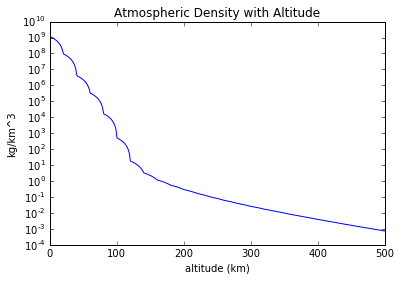

In [3]:
def visualizeDensity():
    xnew = numpy.arange(0, 500000, .1)/1000.
    ynew = density(xnew)
    plt.plot(xnew, ynew)
    plt.xlabel('altitude (km)');plt.ylabel('kg/km^3')
    plt.title('Atmospheric Density with Altitude')
    plt.yscale('log');plt.show()
visualizeDensity()

This is a shitty interpolation, but it's fine for a first pass through this analysis. Rewriting drag in terms of the state variables, we have:

\begin{align}
||\underline{F}_d|| &= \frac{1}{2}C_dA \rho \underline{V}_s^T\underline{V}_s\\
&= \frac{C_d}{2}A({\underline{q}})\rho({\underline{r}})\left(\underline{V}({\underline{r}},{\underline{\dot{r}}})\right)^T\left(\underline{V}({\underline{r}},{\underline{\dot{r}}})\right)
\end{align}

The direction of this force depends somewhat on the attitude of the spacecraft. Many of the incident particles will be scattered randomly, leading to a force opposite the relative velocity of the atmosphere and chip. Some particles, however, will be reflected off the surface, leading to a force opposite the normal to the chip surface.

#### Parameters

Define some parameters relevant to drag. These include the drag coefficient, the spacecraft mass (converted to kg), the surface area (converted to m^2), and the angular velocity of the Earth.

In [4]:
h = .035*1000                                              # spacecraft height, mm
w = .035*1000                                              # spacecraft width, mm
d = .002*1000                                              # spacecraft depth, mm
Az = numpy.array([[h*d, h*d, h*h]]).T                      # z-direction coil surface (m^2)
A = h*h                                                    # surface area (mm^2)
Cd = 2.2                                                   # drag coefficient
mass = .006                                                # mass of spacecraft, kg
omega_earth = numpy.array([[0., 0., 7.2921159e-5]]).T      # angular velocity of Earth, rad/sec

#### Helper Functions

Define some functions for calculating the relative velocity of the atmosphere, the effective surface area of the spacecraft, and the atmospheric density.

In [5]:
def crs(vector):
    first = vector[0][0]
    second = vector[1][0]
    third = vector[2][0]
    return numpy.array([[0., -third, second],
                        [third, 0., -first],
                        [-second, first, 0.]])

def getVs(position, velocity):
    return velocity - numpy.dot(crs(omega_earth), position)

def getDensity(position):
    return density(numpy.linalg.norm(position) - R_e)

#### Drag Function

###### Note: For now the attitude dynamics are still unmodeled. Instead, the effective area is randomized to a number between the thin edge area and the surface area of the chip. The attitude and orbital dynamics are coupled in a later section. It is furthermore assumed that the interaction with the atmosphere is purely diffuse, such that the atmosphere slows the chip in the direction of the relative velocity between the chip and the atmosphere.

In [65]:
effectiveArea = numpy.random.uniform(0., (h/1000./1000.)**2.)

Acceleration from drag force, opposite direction of relative velocity with provided (randomized) effective area:

In [66]:
def getDragDecoupled(X):
    position = numpy.array([X[0:3]]).T
    velocity = numpy.array([X[3:6]]).T
    
    Vs = getVs(position, velocity)
    Aeff = effectiveArea
    rho = getDensity(position)
        
    return 0.5*Aeff*rho*numpy.dot(Vs.T, Vs)[0][0]/mass*(-1*Vs/numpy.linalg.norm(Vs))

### Implementation

#### Gravitational Parameters

Define the necessary paramters for the problem. These include the standard gravitational parameter of the Earth and the J2 constant.

In [58]:
mu_e = 398600.4418   # Earth graviational parameter, (km^3)/(sec^2)
J2   = 1.7555e10     # J2, (km^5)/(sec^2)
R_e  = 6371.         # Radius of Earth, km

#### Derivatives Function

Write a function that takes the state, $\begin{bmatrix}x & y & z & \dot{x} & \dot{y} & \dot{z}\end{bmatrix}$ and returns the time derivative of each state variable, $\begin{bmatrix}\dot{x} & \dot{y} & \dot{z} & \ddot{x} & \ddot{y} & \ddot{z}\end{bmatrix}$.

In [59]:
def orbitalDerivatives(X, t):
    x, y, z, xdot, ydot, zdot = X
    
    R = (x**2. + y**2. + z**2.)**(1./2.)
    term0 = -mu_e/(R**3.)
    term1 = (5.*J2*(-x**2. - y**2. + 2.*(z**2.)))/(2.*(R**7.))
    term2 = J2/(R**5.)
    
    drag = getDragDecoupled(X)
    
    xddot = term0*x + term1*x + term2*x + drag[0][0]
    yddot = term0*y + term1*y + term2*y + drag[1][0]
    zddot = term0*z + term1*z - term2*z*2. + drag[2][0]
    
    return [xdot, ydot, zdot, xddot, yddot, zddot]

#### Simulation Parameters

Define some parameters relevant to the simulation. These include total runtime and stepsize, and initial conditions assuming ISS deployment.

In [60]:
totaltime = numpy.arange(0, 259200, 100)
initial_position = numpy.array([400., 0., 0.])
initial_velocity = numpy.array([0., 4.76001, 6.01425])

#### Run Simulation for Single Set of Initial Conditions

The function below takes a set of initial conditions and propagates them for totaltime (above).

In [61]:
def runOrbitalSim(initial_position, initial_velocity):
    effectiveArea = numpy.random.uniform(0, (h/1000./1000.)**2.)
    pos_init = ((initial_position/numpy.linalg.norm(initial_position))*
                (R_e+numpy.linalg.norm(initial_position)))
    X = numpy.hstack((pos_init, initial_velocity))
    return integrate.odeint(orbitalDerivatives, X, totaltime)

#### Visualize Simulation Results

Takes a list of trajectories, plots them with the Earth.

In [83]:
def showResults(results):
    fig = plt.figure()
    ax = plt.gca(projection='3d')
    ax._axis3don = False
    ax.set_aspect('equal')
    
    for run in results:
        ax.plot(run[:,0], run[:,1], run[:,2])
    deor = (numpy.linalg.norm(initial_position) -
            (numpy.linalg.norm(numpy.array([run[-1,0], run[-1,1],run[-1,2]]))-R_e))
    print 'Amount of deorbit: '+str(deor)+' km'
    
    # Draw the Earth
    u, v = numpy.mgrid[0:2*numpy.pi:20j, 0:numpy.pi:10j]
    x=R_e*numpy.cos(u)*numpy.sin(v)
    y=R_e*numpy.sin(u)*numpy.sin(v)
    z=R_e*numpy.cos(v)
    ax.plot_wireframe(x, y, z, color="r", alpha=0.1)
    
    # Configure the plot
#     ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # Show the plot
    plt.show()

Amount of deorbit: 15.4054417976 km


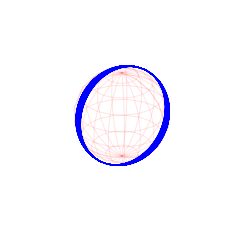

In [84]:
showResults([runOrbitalSim(initial_position, initial_velocity)])

### Monte Carlo

With randomized initial deployment velocities, and randomized effective surface area to the incident atmosphere, we can determine the rate of dispersal of the chips, and the distance of closest approach each orbit. First, create a function that randomizes initial velocity and effective surface area, then accumulates simulation run results:

In [107]:
def runMonteCarlo(N):
    results = [0]*N
    for i in range(N):
        vel = numpy.random.randn(3,1)
        vel = (vel/numpy.linalg.norm(vel))*numpy.random.uniform(0, .002)
#         global effectiveArea
#         effectiveArea = numpy.random.uniform(0., (h/1000./1000.)**2.)
        results[i] = runOrbitalSim(initial_position, initial_velocity+vel.T[0])
    return results

Now a function that visualizes these results. We are interested in learning how the distribution of the chips changes with time. One way of representing this information is with the standard deviation of the positions of all of the chips.

In [108]:
def showMonteCarloResults(results):
    xpositions = numpy.zeros((len(results), len(results[0][:,0])))
    ypositions = numpy.zeros((len(results), len(results[0][:,0])))
    zpositions = numpy.zeros((len(results), len(results[0][:,0])))
    for i in range(len(results)):
        xpositions[i,:] = results[i][:,0]
        ypositions[i,:] = results[i][:,1]
        zpositions[i,:] = results[i][:,2]
    xstd = numpy.std(xpositions, axis=0)*1000.
    ystd = numpy.std(ypositions, axis=0)*1000.
    zstd = numpy.std(zpositions, axis=0)*1000.
    plt.plot(totaltime/60/60, xstd, label='std of x position')
    plt.plot(totaltime/60/60, ystd, label='std of y position')
    plt.plot(totaltime/60/60, zstd, label='std of z position')
    plt.title('Standard Deviation of Chips vs. Time, Randomized Initial Conditions, N=%d Runs'%len(results))
    plt.xlabel('Time (hrs)')
    plt.ylabel('m')
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.show()

With randomized effective surface areas:

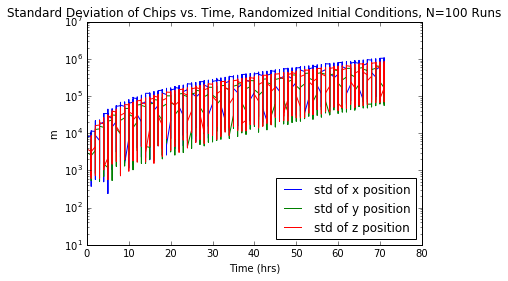

In [105]:
results = runMonteCarlo(100)
showMonteCarloResults(results)

With identical effective surface areas:

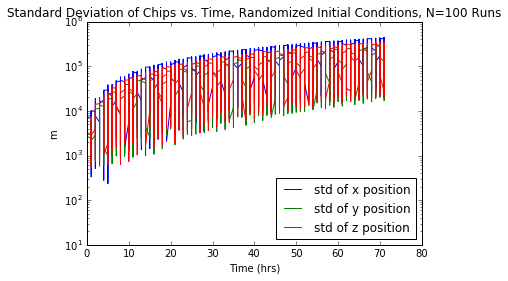

In [109]:
results = runMonteCarlo(100)
showMonteCarloResults(results)

## Attitude Dynamics

### Theory

#### General Expression

We wish to find the equation of motion for a spacecraft tumbling through space. In order to do this, we can take the time derivative of the angular momentum vector.

\begin{align}
{}^{B}{\bf{H}} = {}^{B}\begin{bmatrix}H_{x} & H_{y} & H_{z}\end{bmatrix} \cdot ^{B}\begin{bmatrix}
{\bf{\hat{i}}}_{B}&
{\bf{\hat{j}}}_{B}&
{\bf{\hat{k}}}_{B}
\end{bmatrix}^{T}
\end{align}

Taking the time-derivative in an inertial frame:

\begin{align}
\overset{N}{{\bf{H}}} &= {}^{B}\begin{bmatrix}\dot{H}_{x} & \dot{H}_{y} & \dot{H}_{z}\end{bmatrix} \cdot ^{B}\begin{bmatrix}
{\bf{\hat{i}}}_{B}&
{\bf{\hat{j}}}_{B}&
{\bf{\hat{k}}}_{B}
\end{bmatrix}^{T} + 
{}^{B}\begin{bmatrix}H_{x} & H_{y} & H_{z}\end{bmatrix} \cdot ^{B}\begin{bmatrix}
{\bf{\dot{\hat{i}}}}_{B}&
{\bf{\dot{\hat{j}}}}_{B}&
{\bf{\dot{\hat{k}}}}_{B}
\end{bmatrix}^{T} = 0 \text{ (no external torques)}\\
&= \overset{B}{{\bf{H}}} + ({\bf{\omega}}^{B/N} \times {}^{B}{\bf{H}})
\end{align}

#### Chipsat and Kane Damper Angular Momenta

Write down the angular momentum vector:

\begin{align}
{\bf{H}}_{tot} = {\bf{h}}_{spacecraft} + h_{antennae}
\end{align}

The antennae dissipate energy, ultimately leading to a flatspin about chipsat maximum axis. For now, I will model them as approximately Kane Dampers.

\begin{align}
{\bf{h}}_{spacecraft} &= I_{B}\cdot {\bf{\omega}}^{B/N}\\
{\bf{h}}_{damper} &= I_{D} \cdot {\bf{\omega}}^{D/N}\\
&= I_{D}\cdot \left({\bf{\omega}}^{D/B} + {\bf{\omega}}^{B/N}\right)
\end{align}

#### Time Derivatives

In this case, the only source of torque is from the torque coils. This leads to the differential equation:

\begin{align}
\overset{N}{\bf{h}}_{spacecraft} &= I_{B} \cdot \dot{\omega}^{B/N} + \omega^{B/N} \times \left[I_{B} \cdot \omega^{B/N}\right] = \tau_{D} + \tau_{coils} = c\omega^{D/B}+\tau_{coils}\\
\overset{N}{\bf{h}}_{damper} &= I_{D} \cdot \dot{\omega}^{D/N} + \omega^{B/N} \times \left[I_{D} \cdot \omega^{D/N}\right] = -\tau_{D} = -c\omega^{D/B}\\
&= I_{D} \cdot \left(\dot{\omega}^{D/B} + \dot{\omega}^{B/N}\right) + \omega^{B/N} \times \left[ I_{D} \cdot \left(\omega^{D/B} + \omega^{B/N}\right)\right] + c\omega^{D/B}
\end{align}

Solving each of the above equations:

\begin{align}
\dot{\omega}^{B/N} &= -I_{B}^{-1}\left[\omega^{B/N} \times \left[I_{B} \cdot \omega^{B/N}\right] - c\omega^{D/B} + \tau_{coil}\right]\\
\dot{\omega}^{D/B} &= -I_{D}^{-1}\left[I_{D} \cdot \dot{\omega}^{B/N} + \omega^{B/N} \times \left[ I_{D} \cdot \left(\omega^{D/B} + \omega^{B/N}\right)\right] + c\omega^{D/B}\right]\\
&= -I_{D}^{-1}\left[I_{D} \cdot \left(-I_{B}^{-1}\left[\omega^{B/N} \times \left[I_{B} \cdot \omega^{B/N}\right] - c\omega^{D/B} + \tau_{coil}\right]\right) + \omega^{B/N} \times \left[ I_{D} \cdot \left(\omega^{D/B} + \omega^{B/N}\right)\right] + c\omega^{D/B}\right]
\end{align}

where:

\begin{align}
\tau_{coils} &= \sum_{i=1}^{3}\tau_{i}\\
&= \sum_{i=1}^{3}{\bf{\mu}}_{i} \times {\bf{B}}\\
&= N\sum_{i=1}^{3}i_{i}\left({\bf{A}}_{i}\times{\bf{B}}\right)\\
&= N i_{z}\left({\bf{A}}_{z}\times{\bf{B}}\right)
\end{align}

In the above expression, $N$ is the number of loops for each torque coil, $i$ is the current in the loop, ${\bf{A}}$ is the coil area, and ${\bf{B}}$ is the magnetic field vector. Rewriting:

\begin{align}
\dot{\omega}^{B/N} &= -I_{B}^{-1}\left[\omega^{B/N} \times \left[I_{B} \cdot \omega^{B/N}\right] - c\omega^{D/B} + N i_{z}\left({\bf{A}}_{z}\times{\bf{B}}\right)\right]\\
\dot{\omega}^{D/B} &= -I_{D}^{-1}\left[I_{D} \cdot \dot{\omega}^{B/N} + \omega^{B/N} \times \left[ I_{D} \cdot \left(\omega^{D/B} + \omega^{B/N}\right)\right] + c\omega^{D/B}\right]\\
&= -I_{D}^{-1}\left[I_{D} \cdot \left(-I_{B}^{-1}\left[\omega^{B/N} \times \left[I_{B} \cdot \omega^{B/N}\right] - c\omega^{D/B} + N i_{z}\left({\bf{A}}_{z}\times{\bf{B}}\right)\right]\right) + \omega^{B/N} \times \left[ I_{D} \cdot \left(\omega^{D/B} + \omega^{B/N}\right)\right] + c\omega^{D/B}\right]
\end{align}

#### The Magnetic Field

For now, let us assume that the magnetic field is fixed in the inertial frame, and any perceived change in the direction of that field is due to spacecraft rotation. This assumption can be expressed as:

\begin{align}
{}^{B}{{\bf{B}}} &= A(q){}^{N}{\bf{B}}\\
&= \begin{bmatrix}
1 - 2q_2^2 - 2q_3^2 & 2q_1q_2 - 2q_3q_4 & 2q_1q_3 + 2q_2q_4\\
2q_1q_2 + 2q_3q_4 & 1 - 2q_1^2 - 2q_3^2 & 2q_2q_3 - 2q_1q_4\\
2q_1q_3 - 2q_2q_4 & 2q_1q_4 + 2q_2q_3 & 1 - 2q_1^2 - 2q_2^2
\end{bmatrix}{}^{N}{\bf{B}}
\end{align}

where ${}^{B}{\bf{B}}$ is the magnetic field vector in the spacecraft body frame - measured by the magnetometer. $A(q)$ is the rotation matrix formed from the spacecraft quaternion, and $q_{1,2,3,4}$ are the components of the quaternion. The rate of change of the magnetic field in the spacecraft body frame is given by:

\begin{align}
\overset{N}{{\bf{B}}} &= \overset{B}{{\bf{B}}} + \omega^{B/N} \times {}^{B}{\bf{B}} = 0 \hspace{5mm} \text{(Assuming fixed inertial magnetic field)}\\
&\rightarrow \overset{B}{\bf{B}} = -\omega^{B/N}\times{}^{B}{\bf{B}}
\end{align}

#### Quaternion

The rate of change of the quaternion is also expressed as a differential equation related to the angular velocity of the spacecraft.

\begin{align}
\dot{q} &= \frac{1}{2} \omega \otimes q\\
&= \frac{1}{2}\begin{bmatrix}
0 & \omega_{z} & -\omega_y & \omega_x\\
-\omega_z & 0 & \omega_x & \omega_y\\
\omega_y & -\omega_x & 0 & \omega_z\\
-\omega_x & -\omega_y & -\omega_z & 0
\end{bmatrix}\begin{bmatrix}
q_1 \\ q_2 \\ q_3 \\ q_4\end{bmatrix}
\end{align}

The result is a set of coupled differential equations. To solve for the motion of the spacecraft and the motion of the magnetic field in the spacecraft's frame, we numerically integrate the coupled equations. In this case, the state is $\begin{bmatrix}q_1 & q_2 & q_3 & q_4 & \omega_x & \omega_y & \omega_z & \omega^D_x & \omega^D_y & \omega^D_z & i_z\end{bmatrix}$.

### Implementation

#### Parameters

Define some parameters relevant to the rotational dynamics of the chipsat.

In [33]:
m =  mass*1000                                             #spacecraft mass, g
Ib = numpy.array([[(1./12.)*m*(h**2. + d**2.), 0., 0.],
                  [0., (1./12.)*m*(w**2. + d**2.), 0.],
                  [0., 0., (1./12.)*m*(w**2. + h**2.)]])   #spacecraft inertia tensor
N=12.                                                      #number of loops in each coil
B = numpy.array([[0., 0., 20e-6]]).T*1000                  #inertial magnetic field, (gram-Teslas)
mdamp = .003*1000                                          #damper mass, g
mrad = .03*1000                                            #damper radius, mm
c = 10.                                                    #damping coefficient
Id = numpy.array([[(2./5.)*mdamp*mrad**2., 0., 0.],
                  [0., (2./5.)*mdamp*mrad**2., 0.],
                  [0., 0., (2./5.)*mdamp*mrad**2.]])       #damper inertia tensor

#### Helper Functions

Some helper functions. The first forms the cross product matrix, the second forms the skew-symmetric cross product matrix for the angular velocity, and the third forms a direction cosine matrix from a quaternion.

In [34]:
def quatcrs(omega):
    wx, wy, wz = omega[0][0], omega[1][0], omega[2][0]
    return numpy.array([[0., wz, -wy, wx],
                        [-wz, 0., wx, wy],
                        [wy, -wx, 0., wz],
                        [-wx, -wy, -wz, 0.]])

def formA(q):
    q1, q2, q3, q4 = q[0][0], q[1][0], q[2][0], q[3][0]
    return numpy.array([[1. - 2.*q2**2. - 2.*q3**2., 2.*q1*q2 - 2.*q3*q4, 2.*q1*q3 + 2.*q2*q4],
                        [2.*q1*q2 + 2.*q3*q4, 1.-2.*q1**2. - 2.*q3**2., 2.*q2*q3 - 2.*q1*q4],
                        [2.*q1*q3 - 2.*q2*q4, 2.*q1*q4 + 2.*q2*q3, 1.-2.*q1**2. - 2.*q2**2.]])

#### Derivative Function

The function below takes the state as an input, and returns the derivative of each state variable.

In [35]:
def rotationalDerivative(X, t):
    #unpack
    q1, q2, q3, q4, omegax, omegay, omegaz, omegadx, omegady, omegadz, iz = X
    
    #create vectors
    quaternion = numpy.array([[q1, q2, q3, q4]]).T
    omega = numpy.array([[omegax, omegay, omegaz]]).T
    omegad = numpy.array([[omegadx, omegady, omegadz]]).T
    
    #find magnetic field
    Bvec = numpy.dot(formA(quaternion), B)#---------------------------------------magnetic field, body frame
    
    #spacecraft derivative
    control = N*iz*numpy.dot(crs(Az), Bvec)#--------------------------------------control term
    damp = c*omegad#--------------------------------------------------------------damper term
    first_term = numpy.dot(crs(omega), numpy.dot(Ib, omega))#---------------------first term in parentheses
    omega_dot = numpy.dot(-1.*pinv(Ib), first_term - damp + control)#-------------spacecraft body time derivative
    
    #damper derivative
    first_term_d = numpy.dot(Id, omega_dot)#--------------------------------------first term in parentheses
    second_term_d = numpy.dot(crs(omega), numpy.dot(Id, omegad+omega))#-----------second term in parentheses
    omegad_dot = numpy.dot(-1.*pinv(Id), first_term_d + second_term_d + damp)#----damper time derivative
    
    #quaternion derivative
    q_dot = .5*numpy.dot(quatcrs(omega), quaternion)#-----------------------------quaternion time derivative
    
    #control input derivative
    izdot = numpy.array([0])#-----------------------------------------------------control derivative
    
    #return derivatives
    derivs = numpy.hstack((q_dot.T[0], omega_dot.T[0], omegad_dot.T[0], izdot))#--derivatives
    return derivs

#### Simulation Parameters

Define parameters relevant to the simulation

In [36]:
attitudetime = numpy.arange(0, 500, 1)
initial_quaternion = numpy.array([0., 0., 0., 1.])
# initial_quaternion = numpy.array([0.7071067811865476, 0., 0.7071067811865476, 0.])
initial_quaternion = initial_quaternion/numpy.linalg.norm(initial_quaternion)
initial_omega = numpy.array([0., 1., 1.])
initial_omegad = numpy.array([0., 0., 0.])
initial_iz = numpy.array([0.])

#### Run Simulation for Single Set of Initial Conditions

In [37]:
def runAttitudeSim(initial_quaternion, initial_omega, initial_omegad, initial_iz):
    X = numpy.hstack((initial_quaternion, initial_omega, initial_omegad, initial_iz))
    return integrate.odeint(rotationalDerivative, X, attitudetime)

#### Visualize Simulation Results

The function below takes a list of attitude simulation results and plots them.

In [38]:
def showAttitudeResults(results):
    for run in results:
        plt.title('Quaternion')
        plt.xlabel('Time (sec)')
        plt.plot(attitudetime,run[:,0], label='$q_1$')
        plt.plot(attitudetime,run[:,1], label='$q_2$')
        plt.plot(attitudetime,run[:,2], label='$q_3$')
        plt.plot(attitudetime,run[:,3], label='$q_4$')
        plt.ylim([-1.1,1.1])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
    for run in results:
        plt.title('Spacecraft Angular Velocity')
        plt.xlabel('Time (sec)')
        plt.ylabel('Rad/Sec')
        plt.plot(attitudetime,run[:,4], label='$\omega_x^{B/N}$')
        plt.plot(attitudetime,run[:,5], label='$\omega_y^{B/N}$')
        plt.plot(attitudetime,run[:,6], label='$\omega_z^{B/N}$')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
    for run in results:
        plt.title('Damper Relative Angular Velocity')
        plt.xlabel('Time (sec)')
        plt.ylabel('Rad/Sec')
        plt.plot(attitudetime,run[:,7], label='$\omega_x^{D/B}$')
        plt.plot(attitudetime,run[:,8], label='$\omega_y^{D/B}$')
        plt.plot(attitudetime,run[:,9], label='$\omega_z^{D/B}$')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

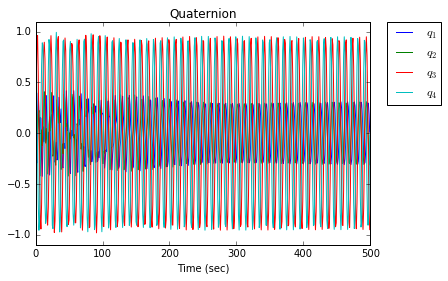

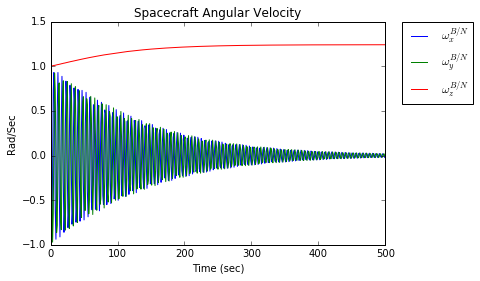

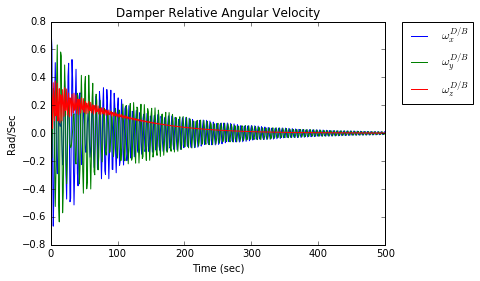

In [39]:
showAttitudeResults([runAttitudeSim(initial_quaternion, initial_omega,
                                    initial_omegad, initial_iz)])

## The Coupled System

In [8]:
def getAECI(quaternion):
    return numpy.dot(formA(quaternion), area)

def getAeff(Vs, AECI):
    return abs(numpy.dot(AECI.T, Vs/numpy.linalg.norm(Vs))[0][0])

In [112]:
def getDrag(X):
    position = numpy.array([X[0:3]]).T
    velocity = numpy.array([X[3:6]]).T
    quaternion = numpy.array([X[6:10]]).T
    omega = numpy.array([X[10:13]]).T
    omega_d = numpy.array([X[13:16]]).T
    iz = numpy.array([X[17]])
    
    Vs = getVs(position, velocity)
    AECI = getAECI(quaternion)
    Aeff = getAeff(Vs, AECI)
    Aeff = a random number
    rho = getDensity(position)
        
    return 0.5*Aeff*rho*numpy.dot(Vs.T, Vs)[0][0]*(-1*Vs/numpy.linalg.norm(Vs))